#Downloading Dataset

In [1]:
!cp -r /content/drive/MyDrive/Kaggle/kaggle.json /content/

In [2]:
! pip install -q kaggle

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


I used the anime face dataset on [Kaggle](https://www.kaggle.com/datasets/splcher/animefacedataset) provided by splcher

In [ ]:
!kaggle datasets download 'splcher/animefacedataset'
!unzip animefacedataset.zip

#Importing Libraries

In [1]:
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras import backend as K
from keras.layers import Rescaling, Resizing
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback, TensorBoard, BackupAndRestore
from keras import regularizers
import numpy as np
import os
import datetime
import gc #garbage collector
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2
import psutil
from random import shuffle

In [2]:
wannaTrain = True
scratch = True

Checking if i'm using GPU or CPU

In [3]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


#Dataset Preprocessing

All images are squared so we just define one dim and use it twice

In [4]:
hight = 64

In [5]:
path_to_img = "/content/images/"

Loading images paths

In [6]:
dataset = [path_to_img + i for i in os.listdir(path_to_img)]
print(len(dataset))
print(dataset[:3])

63565
['/content/images/52892_2016.jpg', '/content/images/44343_2013.jpg', '/content/images/52408_2015.jpg']


In [7]:
shuffle(dataset)

In [8]:
split_index = int(0.75 * len(dataset))
ae_train, ae_test = np.split(dataset, [split_index])

In [9]:
split_index = int(0.8 * len(ae_train))
ae_train, ae_vali= np.split(ae_train, [split_index])

Creating the dataset

In [10]:
ae_dataset = []
for i in tqdm(dataset):
  ae_dataset.append(cv2.resize(np.array(cv2.imread(i)[:,:,::-1]),(hight, hight)).astype("float32")/255.0)

100%|██████████| 63565/63565 [00:53<00:00, 1196.88it/s]


In [11]:
ae_dataset = np.array(ae_dataset)

In [12]:
ae_dataset.shape

(63565, 64, 64, 3)

We create the train and test sets

In [13]:
np.random.shuffle(ae_dataset)

In [14]:
split_index = int(0.70 * len(ae_dataset))
ae_train, ae_test = np.split(ae_dataset, [split_index])

In [15]:
split_index = int(0.8 * len(ae_train))
ae_train, ae_vali= np.split(ae_train, [split_index])

In [16]:
ae_train.shape, ae_test.shape, ae_vali.shape

((35596, 64, 64, 3), (19070, 64, 64, 3), (8899, 64, 64, 3))

In [17]:
np.save('ae_train', ae_train)
np.save('ae_test', ae_test)
np.save('ae_vali', ae_vali)

Show some exemples

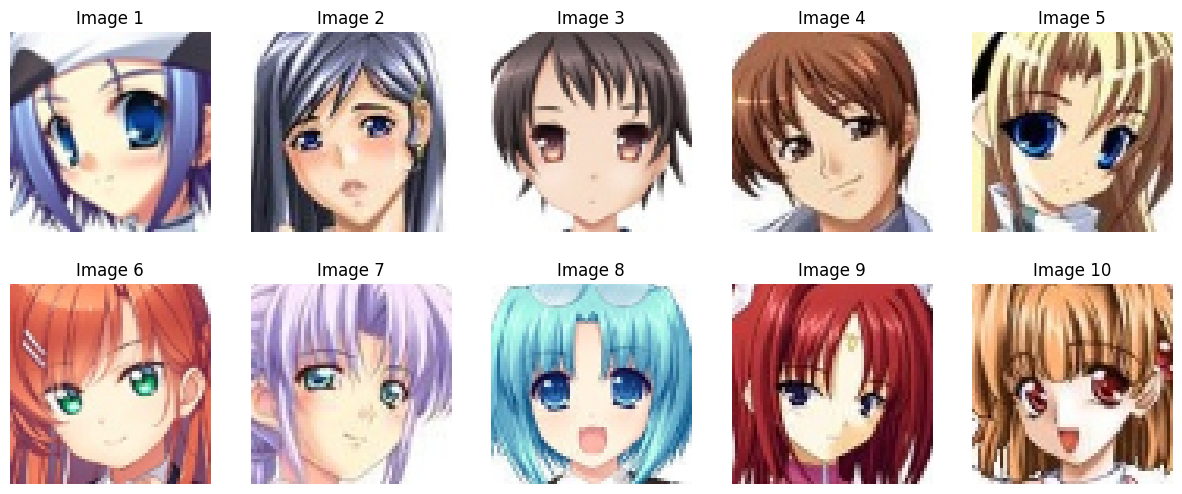

In [18]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
      ax[i, j].imshow(ae_train[i*5 + j])
      ax[i, j].axis('off')
      ax[i, j].set_title(f'Image {i*5 + j + 1}')
plt.show()

Delete to free some ram space

In [19]:
del ae_dataset
del ae_train
del ae_test
del ae_vali

In [20]:
gc.collect()

45

#Encoder Part

In [21]:
latentDim = 2048
inputShape = (hight, hight, 3)
chanDim = 3
depth = 1

In [22]:
inputs = Input(shape=inputShape)
x = inputs


x = Conv2D(256, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2D(128, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

volumeSize = K.int_shape(x)
x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dense(2048, activation='relu')(x)
latent = Dense(latentDim)(x)

In [23]:
encoder = Model(inputs, latent, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 256)       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                           

#Decoder part

In [24]:
latentInputs = Input(shape=(latentDim,))
# x = Dense(2048, activation='relu')(latentInputs)
# x = Dense(4096, activation='relu')(x)
x = Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

In [25]:
x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(256, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(3, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)

In [26]:
decoder = Model(latentInputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense_1 (Dense)             (None, 4096)              8392704   
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                           

In [27]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        (None, 2048)              8768448   
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         8807363   
                                                                 
Total params: 17,575,811
Trainable params: 17,574,019
Non-trainable params: 1,792
_________________________________________________________________


In [28]:
encoder.build(inputShape)
decoder.build(inputShape)
autoencoder.build(inputShape)

In [29]:
autoencoder.compile(loss="mse", optimizer=Adam(learning_rate=1e-3))

#Spliting datasets

In [30]:
checkpoint_path = "/content/drive/MyDrive/AutoEncoders/best_model_64.h5"
log_dir = "/content/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
backup_dir = '/content/drive/MyDrive/AutoEncoders/backup.h5'

In [31]:
backups = BackupAndRestore(backup_dir, save_freq="epoch", delete_checkpoint=True, save_before_preemption=False)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, write_graph=True, update_freq='epoch',
                          profile_batch=0, embeddings_freq=0, embeddings_metadata=None, embeddings_data=None)
callbacks = [checkpoint]

i load the latest best model

In [32]:
filename = 'best_model.h5'
!cp -r /content/drive/MyDrive/AutoEncoders/best_model_64.h5 /content/
print(f'The file {filename} was copied.')


The file best_model.h5 was copied.


if the file doesn't exist we just train from scratch

In [33]:
if os.path.exists(filename) and (not scratch):
    autoencoder.load_weights('/content/best_model.h5')
    print('weights loaded')
else:
  print('not loaded')

not loaded


In [34]:
EPOCHS = 50
Batch_Size = 128

In [35]:
train = np.load('/content/ae_train.npy')
validation = np.load('/content/ae_vali.npy')

In [36]:
history = autoencoder.fit(
		train,
		train,
		epochs=EPOCHS,
		validation_data=(validation, validation),
		batch_size = Batch_Size,
		callbacks=callbacks)

Epoch 1/50
279/279 [==============================] - ETA: 0s - loss: 0.0216
Epoch 1: val_loss improved from inf to 0.05533, saving model to /content/drive/MyDrive/AutoEncoders/best_model_64.h5
279/279 [==============================] - 84s 255ms/step - loss: 0.0216 - val_loss: 0.0553
Epoch 2/50
278/279 [============================>.] - ETA: 0s - loss: 0.0105
Epoch 2: val_loss improved from 0.05533 to 0.01573, saving model to /content/drive/MyDrive/AutoEncoders/best_model_64.h5
279/279 [==============================] - 75s 269ms/step - loss: 0.0105 - val_loss: 0.0157
Epoch 3/50
278/279 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 3: val_loss improved from 0.01573 to 0.00840, saving model to /content/drive/MyDrive/AutoEncoders/best_model_64.h5
279/279 [==============================] - 72s 258ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 4/50
278/279 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 4: val_loss improved from 0.00840 to 0.00788, savin

In [37]:
del train
del validation

In [38]:
gc.collect()

1808

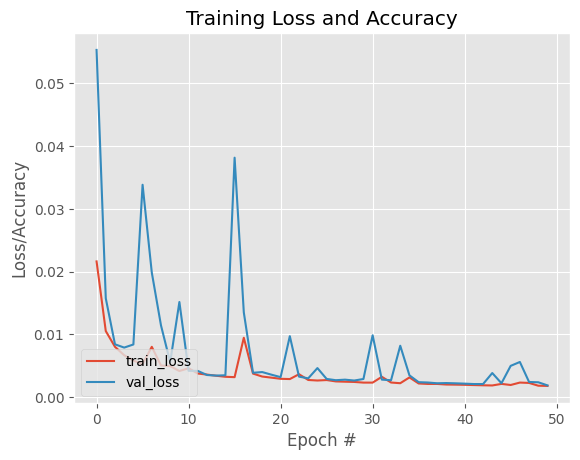

In [39]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [51]:
ae_test = np.load('/content/ae_test.npy')

In [41]:
autoencoder.load_weights('/content/drive/MyDrive/AutoEncoders/best_model_64.h5')

In [42]:
autoencoder.save('/content/drive/MyDrive/AutoEncoders/animeFaceModel.h5')

In [53]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(ae_test)
outputs = None

[INFO] making predictions...
596/596 [==============================] - 14s 24ms/step


In [58]:
from sklearn.metrics import mean_squared_error
import random

In [55]:
mse = mean_squared_error(np.reshape(ae_test, (-1, 3)), np.reshape(decoded, (-1, 3)))
print(mse)

0.001550879


In [56]:
decoded.shape

(19070, 64, 64, 3)

In [59]:
randimg = random.sample(range(decoded.shape[0]), 5)

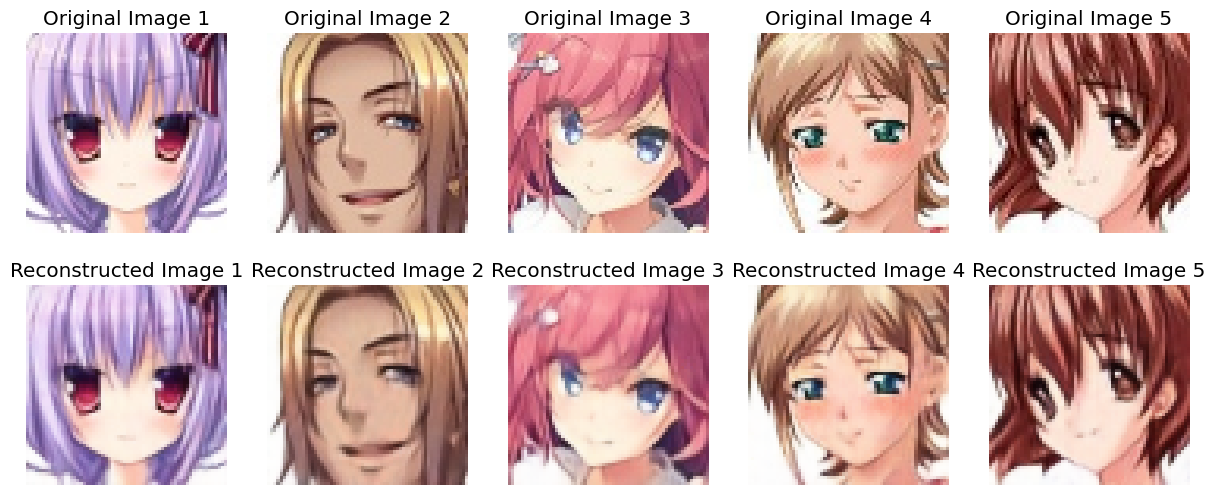

In [61]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
      if i == 0:
        ax[i, j].imshow(ae_test[1*5 + randimg[j]])
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Original Image {0*5 + j + 1}')
      else:
        ax[i, j].imshow(decoded[1*5 + randimg[j]])
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Reconstructed Image {0*5 + j + 1}')

plt.show()

In [62]:
del ae_test
del decoded

In [63]:
gc.collect()

25962